In [1]:
%%capture
!pip install shapely
!pip install geopandas
!pip install folium
!pip install config
!pip install timezonefinder
!pip install descartes

In [2]:
#Function to get isolines  
from shapely.geometry import Polygon,  Point
from shapely import wkt
import requests
import json
import geopandas as gpd
from geopandas import GeoSeries
import folium
import config
import pandas as pd

import timezonefinder as tf
from timezonefinder import TimezoneFinder
tf = TimezoneFinder()
from datetime import datetime, timezone, date, time, timedelta

import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline
import descartes

In [3]:
# Get LatLon from address
def get_latlon(event_address):
    get_latlon = f'https://geocoder.ls.hereapi.com/6.2/geocode.json?searchtext={event_address}&gen=9&apiKey=CvCsf7byXWXESq3FtlGpWXUWRqYEnj-W8k9amDXCJJ4'
    js_latlon = requests.get(url = get_latlon).json()['Response']['View'][0]['Result'][0]['Location']['DisplayPosition']
    return js_latlon

# Get UTC Timezone offset based on LatLon
def get_offset(*, Latitude, Longitude):
    from datetime import datetime
    from pytz import timezone, utc
    today = datetime.now()
    tz_target = timezone(tf.certain_timezone_at(lng=Longitude, lat=Latitude))
    today_target = tz_target.localize(today)
    today_utc = utc.localize(today)
    return(int((today_utc - today_target).total_seconds() / 3600))

# Convert Arrival Time to ISO format
def get_isotime(start_time, event_date, utc_offset):
    t_24 = datetime.strptime(start_time,'%I:%M%p')
    d = datetime.strptime(event_date,'%Y-%m-%d')
    dt_24 = datetime.combine(d.date(),t_24.timetz(),tzinfo=timezone(timedelta(hours=utc_offset)))
    arrival_time = dt_24.isoformat(sep='T')
    return arrival_time

# Get Isoline from HERE API
def get_isodata(lat,lon,
                trip_mode,
                trip_duration,
                arrival_time,
                meters_per_pixel):   
    try: 
        obtain_isoline = (f'https://isoline.route.ls.hereapi.com/routing/7.2/calculateisoline.json' +
        f'?apiKey=CvCsf7byXWXESq3FtlGpWXUWRqYEnj-W8k9amDXCJJ4'+
        f'&mode=fastest;{trip_mode}'+
        f'&destination=geo!{lat},{lon}'+
        f'&range={trip_duration}'+
        f'&rangetype=time'+
        f'&resolution={meters_per_pixel}'+
        f'&singlecomponent=true'+
        f'&arrival={arrival_time}')
        js_isoline = requests.get(url = obtain_isoline).json()['response']['isoline'][0]['component'][0]['shape']
        coords = Polygon([(float(x.split(',')[1]), float(x.split(',')[0])) for x in js_isoline])
        geojs = gpd.GeoSeries([coords])
        geojs.crs = {'init' : 'epsg:4326'}
        return geojs
    except KeyError:
        js = requests.get(url).json()
        print(js)
        raise ValueError("HereAPI doesn't have data requested")
    except IndexError:
        print(js)
        raise ValueError("HereAPI doesn't have quality data")
        

In [4]:
# User input event details
# Format {event_id: ['Address City State ZIP', '00:00AM/PM', 'YYYY-MM-DD', 'Name of event']}
EVENT_DICT = {181311:['102 Chamber Dr Anamosa, IA 52205','11:00AM','2020-01-03','anamosa'],
              181312:['1712 W 4th St Waterloo, IA 50701','2:00PM','2020-01-03','waterloo'],
              181316:['900 E Main St, Decorah, IA 52101','5:00PM','2020-01-03','decorah'],
              181318:['1800 Clarke Dr Dubuque, IA 52001','11:00AM','2020-01-04','dubuque'],
              181319:['705 F Ave Grundy Center, IA 50638','2:30PM','2020-01-04','grundy'],
              181321:['308 S Pennsylvania Ave, Mason City, IA 50401','5:00PM','2020-01-04','mason'],
              181323:['1900 Lakewood Dr Boone, IA 50036','10:00AM','2020-01-05','boone']
             }

# Output table
OUTPUT_TABLE = 'bernie_nmarchio2.isoline_test'

# Mode (options 'car' or 'pedestrian')
transit_mode = ['car']

# Max and min travel range in seconds (and increment of isoline series)
max_range = 3600 # 60 minutes
min_range = 300 # 5 minutes
time_increment = 300 # 5 minutes
isoline_resolution = 1000 # meters per pixel, recommended 1000 for 'car' and 100 for 'pedestrian'


In [5]:
# Get isolines geometries and create table
event_object = []
event_gpd = gpd.GeoDataFrame()
for i in EVENT_DICT.items():
    event_coords = get_latlon(event_address=i[1][0].replace(' ','%20'))
    hour_offset = get_offset(**event_coords)
    timestamp = get_isotime(start_time=str(i[1][1]),
                            event_date=str(i[1][2]),
                            utc_offset=hour_offset)
    for commute_mode in transit_mode:
        for commute_time in range(min_range, max_range, time_increment):
            if (commute_mode == 'pedestrian' and commute_time <= 1800) or commute_mode == 'car':
                    isoline = get_isodata(lat=event_coords['Latitude'],
                                          lon=event_coords['Longitude'],
                                          trip_mode=commute_mode,
                                          trip_duration=commute_time,
                                          arrival_time=timestamp,
                                          meters_per_pixel=isoline_resolution)
                    iso_bbox = isoline.envelope
                    search_geom = gpd.GeoDataFrame(geometry = iso_bbox)['geometry'].geometry
                    search_array = [i for i in search_geom.geometry]
                    x,y = search_array[0].exterior.coords.xy
                    df = pd.DataFrame({'event_input':[i],
                                       'event_id':[i[0]],
                                       'event_address':[i[1][0]],
                                       'event_latlon':[event_coords],
                                       'event_time':[timestamp],
                                       'trip_mode': [commute_mode],
                                       'trip_duration_minutes': [commute_time/60],
                                       'search_max_lat':[max(y)],
                                       'search_min_lat':[min(y)],
                                       'search_max_lon':[max(x)],
                                       'search_min_lon':[min(x)]
                                      })
                    isoline_gdf = gpd.GeoDataFrame(df, geometry = isoline)
                    isoline_gdf.crs = {'init':'epsg:4326'}
                    event_gpd = pd.concat([event_gpd, isoline_gdf])


In [6]:
event_gpd.head(n=5)

,event_input,event_id,event_address,event_latlon,event_time,trip_mode,trip_duration_minutes,search_max_lat,search_min_lat,search_max_lon,search_min_lon,geometry
0,"(181311, [102 Chamber Dr Anamosa, IA 52205, 11...",181311,"102 Chamber Dr Anamosa, IA 52205","{'Latitude': 42.10527, 'Longitude': -91.26578}",2020-01-03T11:00:00-06:00,car,5.0,42.160034,42.039185,-91.213989,-91.315613,"POLYGON ((-91.29913 42.08313, -91.29639 42.099..."
0,"(181311, [102 Chamber Dr Anamosa, IA 52205, 11...",181311,"102 Chamber Dr Anamosa, IA 52205","{'Latitude': 42.10527, 'Longitude': -91.26578}",2020-01-03T11:00:00-06:00,car,10.0,42.209473,41.989746,-91.126099,-91.425476,"POLYGON ((-91.40350 42.07764, -91.38428 42.077..."
0,"(181311, [102 Chamber Dr Anamosa, IA 52205, 11...",181311,"102 Chamber Dr Anamosa, IA 52205","{'Latitude': 42.10527, 'Longitude': -91.26578}",2020-01-03T11:00:00-06:00,car,15.0,42.275391,41.923828,-91.032715,-91.513367,"POLYGON ((-91.49139 42.05566, -91.47766 42.061..."
0,"(181311, [102 Chamber Dr Anamosa, IA 52205, 11...",181311,"102 Chamber Dr Anamosa, IA 52205","{'Latitude': 42.10527, 'Longitude': -91.26578}",2020-01-03T11:00:00-06:00,car,20.0,42.297363,41.879883,-90.988770,-91.560059,"POLYGON ((-91.54083 42.06116, -91.53259 42.072..."
0,"(181311, [102 Chamber Dr Anamosa, IA 52205, 11...",181311,"102 Chamber Dr Anamosa, IA 52205","{'Latitude': 42.10527, 'Longitude': -91.26578}",2020-01-03T11:00:00-06:00,car,25.0,42.341309,41.835938,-90.922852,-91.625977,"POLYGON ((-91.60675 42.03918, -91.60400 42.055..."


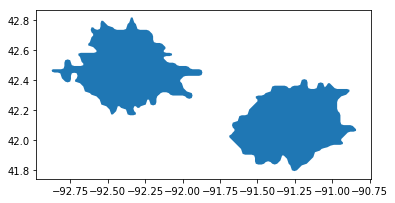

In [7]:
event_gpd.plot()

In [8]:
# Upload isoline geometries table to platform
create_geojson_df = civis.io.dataframe_to_civis(df=event_gpd,
                                                database='Bernie 2020', 
                                                table= f'{OUTPUT_TABLE}_geometries', 
                                                existing_table_rows='drop')
create_geojson_df.result()

{'created_at': '2020-01-02T02:20:51.000Z',
 'error': None,
 'finished_at': '2020-01-02T02:21:44.000Z',
 'id': 196353401,
 'started_at': '2020-01-02T02:20:51.000Z',
 'state': 'succeeded'}

In [9]:
# Assemble where SQL for voterfile and event isoline table
search_area_list = []
for i in event_gpd['event_id'].unique():
    max_of_search_max_lat = event_gpd[(event_gpd["event_id"] == i)]['search_max_lat'].max()
    min_of_search_min_lat = event_gpd[(event_gpd["event_id"] == i)]['search_min_lat'].min()
    max_of_search_max_lon = event_gpd[(event_gpd["event_id"] == i)]['search_max_lon'].max()
    min_of_search_min_lon = event_gpd[(event_gpd["event_id"] == i)]['search_min_lon'].min()
    where_sql_search_area = f''' where (v_latitude >= {min_of_search_min_lat} AND v_latitude <= {max_of_search_max_lat}) AND (v_longitude >= {min_of_search_min_lon} AND v_longitude <= {max_of_search_max_lon})'''
    search_area = {'event_id':i,
                   'where_sql':where_sql_search_area}
    search_area_list.append(search_area)
    

In [61]:
# Assemble full SQL query to intersect voterfile with isolines
isoline_base_sql = []
for i in range(len(search_area_list)):
    where_sql_event = search_area_list[i]['event_id']
    where_sql_person = search_area_list[i]['where_sql']
    base_query =  base_query = f'''-- Query for event_id = {where_sql_event}
    (select * from (select person_id, event_id, event_input, trip_mode, trip_duration_minutes, row_number() over (partition by person_id order by trip_duration_minutes asc) as travel_rank from (select person_id, event_id, event_input, trip_mode, min(trip_duration_minutes) as trip_duration_minutes from (select person_id, event_id, event_input, trip_mode, trip_duration_minutes, ST_Within(voter,event) from 
    (select person_id, ST_SetSRID(ST_MakePoint(v_longitude, v_latitude),4326) as voter from bernie_data_commons.rainbow_analytics_frame {where_sql_person}) a, 
    (select event_id, event_input, trip_mode, trip_duration_minutes, ST_GeomFromText(geometry,4326) as event from (select * from {OUTPUT_TABLE}_geometries where event_id = {where_sql_event} )) b) 
    where st_within is true group by 1,2,3,4)) where travel_rank = 1) '''
    isoline_base_sql.append(base_query)
    
isoline_calculation_sql = "\nunion all\n".join([" {query} ".format(query=q) for q in isoline_base_sql])

In [62]:
create_output_table = f'''
DROP TABLE IF EXISTS {OUTPUT_TABLE};
CREATE TABLE {OUTPUT_TABLE}
  DISTKEY (person_id) 
  AS (select * from 
  {isoline_calculation_sql} 
  );'''

In [63]:
print(create_output_table)


DROP TABLE IF EXISTS bernie_nmarchio2.isoline_test;
CREATE TABLE bernie_nmarchio2.isoline_test
  DISTKEY (person_id) 
  AS (select * from 
   -- Query for event_id = 181311
    (select * from (select person_id, event_id, event_input, trip_mode, trip_duration_minutes, row_number() over (partition by person_id order by trip_duration_minutes asc) as travel_rank from (select person_id, event_id, event_input, trip_mode, min(trip_duration_minutes) as trip_duration_minutes from (select person_id, event_id, event_input, trip_mode, trip_duration_minutes, ST_Within(voter,event) from 
    (select person_id, ST_SetSRID(ST_MakePoint(v_longitude, v_latitude),4326) as voter from bernie_data_commons.rainbow_analytics_frame  where (v_latitude >= 41.7919922 AND v_latitude <= 42.4072266) AND (v_longitude >= -91.6891479 AND v_longitude <= -90.8404541)) a, 
    (select event_id, event_input, trip_mode, trip_duration_minutes, ST_GeomFromText(geometry,4326) as event from (select * from bernie_nmarchio2.isol

In [64]:
output_table = civis.io.query_civis(sql=create_output_table, database='Bernie 2020')
output_table.result().state


'succeeded'